In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split

In [2]:
ratings = pd.read_csv('ratings.dat', names = ['userId','movieId','rating','timestamp'], delimiter='::')
movies = pd.read_csv('movies.dat', names = ['movieId','title','genres'], delimiter='::')

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [3]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [8]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [258]:
ratings.movieId.nunique(), ratings.userId.nunique()

(3706, 6040)

In [9]:
ratings.shape, movies.shape

((1000209, 4), (3883, 3))

In [10]:
train, test = train_test_split(ratings, test_size = 0.2, random_state=15)

In [11]:
train.shape, test.shape

((800167, 4), (200042, 4))

In [12]:
N_users = train.userId.nunique()
N_movies = train.movieId.nunique()
N_users, N_movies

(6040, 3676)

In [13]:
test = test[test.movieId.isin(train.movieId.unique())]
test.shape

(200008, 4)

In [14]:
N_factors = 50
user_factors = np.random.randn(N_users, N_factors)
movie_factors = np.random.randn(N_movies, N_factors)

In [15]:
movie_enum_dict = {k : v for v, k in enumerate(train.movieId.unique())}
user_enum_dict = {k : v for v, k in enumerate(ratings.userId.unique())}

train['movieEnum'] = train.movieId.map(movie_enum_dict)
train['userEnum'] = train.userId.map(user_enum_dict)

test['movieEnum'] = test.movieId.map(movie_enum_dict)
test['userEnum'] = test.userId.map(user_enum_dict)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [16]:
train.rating.mean()

3.5819935088550263

In [17]:
X_train = np.array(train[['userEnum','movieEnum']], dtype = np.int16)
y_train = np.array(train.rating) - 3.5

X_test = np.array(test[['userEnum','movieEnum']], dtype = np.int16)
y_test = np.array(test.rating) - 3.5
X_train.shape, X_test.shape

((800167, 2), (200008, 2))

In [18]:
def rmse(data, labels):
    preds = np.einsum('ij,ij->i',user_factors[data[:,0]], movie_factors[data[:,1]])
    return np.mean((labels - preds)**2)

def sgd_generator(data, labels):
    for i in np.random.permutation(np.arange(len(data))):
        yield data[i], labels[i]

In [19]:
N_epochs = 50
lr = 0.01
reg = 0.1
for epoch in tqdm(range(N_epochs)):
    for (user_ix, movie_ix), rating_i in sgd_generator(X_train, y_train):
        user_i = user_factors[user_ix]
        movie_i = movie_factors[movie_ix]
        pred = np.dot(user_factors[user_ix], movie_factors[movie_ix])
        pred_err = rating_i - pred
        
        user_factors[user_ix] = user_factors[user_ix] + lr * (pred_err*movie_factors[movie_ix] - reg*user_factors[user_ix])
        movie_factors[movie_ix] = movie_factors[movie_ix] + lr * (pred_err*user_factors[user_ix] - reg*movie_factors[movie_ix])
        
    if (epoch+1) % 5 ==0:
        print ('train rmse: {:.3f}, test rmse: {:.3f}'.format(rmse(X_train, y_train), rmse(X_test, y_test)))

  8%|▊         | 4/50 [02:42<31:17, 40.82s/it]

train rmse: 0.779, test rmse: 1.274


 18%|█▊        | 9/50 [06:12<28:00, 40.99s/it]

train rmse: 0.698, test rmse: 0.966


 28%|██▊       | 14/50 [09:35<24:24, 40.68s/it]

train rmse: 0.681, test rmse: 0.879


 38%|███▊      | 19/50 [13:07<21:34, 41.77s/it]

train rmse: 0.671, test rmse: 0.837


 48%|████▊     | 24/50 [16:39<18:21, 42.36s/it]

train rmse: 0.663, test rmse: 0.814


 58%|█████▊    | 29/50 [20:04<14:19, 40.93s/it]

train rmse: 0.658, test rmse: 0.799


 68%|██████▊   | 34/50 [23:32<11:06, 41.68s/it]

train rmse: 0.652, test rmse: 0.789


 78%|███████▊  | 39/50 [27:03<07:40, 41.83s/it]

train rmse: 0.649, test rmse: 0.782


 88%|████████▊ | 44/50 [30:40<04:17, 42.88s/it]

train rmse: 0.645, test rmse: 0.777


 98%|█████████▊| 49/50 [34:13<00:42, 42.12s/it]

train rmse: 0.642, test rmse: 0.773


100%|██████████| 50/50 [34:58<00:00, 43.11s/it]


In [20]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

X = movie_factors
distorsions = []
for k in tqdm(range(2, 50, 2)):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

100%|██████████| 24/24 [01:22<00:00,  5.20s/it]


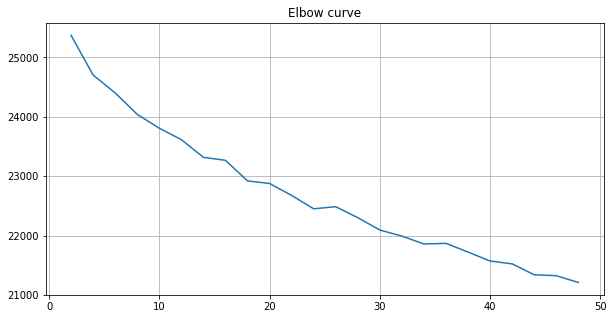

In [21]:
fig = plt.figure(figsize=(10, 5))
plt.plot(range(2, 50, 2), distorsions)
plt.grid(True)
plt.title('Elbow curve')
plt.show()

In [22]:
kmeans = KMeans(n_clusters=10, random_state=7)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=7, tol=0.0001, verbose=0)

In [23]:
clusts = kmeans.predict(X)

In [24]:
Counter(clusts)

Counter({9: 1284,
         7: 1267,
         4: 758,
         0: 95,
         1: 111,
         6: 104,
         8: 3,
         2: 52,
         3: 1,
         5: 1})

In [25]:
clusts_dict = {movie_enum : cluster for movie_enum, cluster in enumerate(clusts)}

In [26]:
movies = movies[movies.movieId.isin(train.movieId.unique())]
movies.shape

(3676, 3)

In [27]:
movies['movieEnum'] = movies.movieId.map(movie_enum_dict)
movies['clusts'] = movies.movieEnum.map(clusts_dict)

In [175]:
genres = [i.split('|') for i in movies.genres.values]
genres_counter = Counter([j for i in genres for j in i])

In [176]:
sorted(genres_counter.items(), key=lambda x:x[1], reverse=True)

[('Drama', 1477),
 ('Comedy', 1157),
 ('Action', 494),
 ('Thriller', 481),
 ('Romance', 457),
 ('Horror', 339),
 ('Adventure', 278),
 ('Sci-Fi', 273),
 ("Children's", 250),
 ('Crime', 200),
 ('War', 141),
 ('Musical', 112),
 ('Documentary', 107),
 ('Animation', 105),
 ('Mystery', 103),
 ('Fantasy', 68),
 ('Western', 66),
 ('Film-Noir', 44)]

In [178]:
def get_genres_for_clust(clust_num):
    clust_genres = [i.split('|') for i in movies[movies.clusts==clust_num].genres.values]
    clust_genres_flattened = [j for i in clust_genres for j in i]
    clusts_counter = Counter(clust_genres_flattened)
    return sorted(clusts_counter.items(), key = lambda x: x[1], reverse = True)

In [179]:
for i in range(len(set(clusts))):
    print ('cluster: {}, top genres: {}'.format(i, get_genres_for_clust(i)[:5]))

cluster: 0, top genres: [('Drama', 649), ('Comedy', 339), ('Romance', 156), ('Thriller', 139), ('Action', 96)]
cluster: 1, top genres: [('Drama', 51), ('Comedy', 28), ('Romance', 8), ('Crime', 6), ('Horror', 6)]
cluster: 2, top genres: [('Comedy', 288), ('Action', 163), ('Horror', 156), ('Drama', 118), ('Thriller', 111)]
cluster: 3, top genres: [('Drama', 53), ('Comedy', 23), ('Documentary', 12), ('Romance', 10), ('Horror', 7)]
cluster: 4, top genres: [('Drama', 48), ('Comedy', 23), ('Thriller', 9), ('Romance', 6), ('Action', 5)]
cluster: 5, top genres: [('Drama', 482), ('Comedy', 416), ('Action', 213), ('Romance', 204), ('Thriller', 201)]
cluster: 6, top genres: [('Drama', 1)]
cluster: 7, top genres: [('Drama', 27), ('Comedy', 15), ('Romance', 7), ('Action', 6), ('Documentary', 5)]
cluster: 8, top genres: [('Comedy', 1), ('Drama', 1), ('Western', 1)]
cluster: 9, top genres: [('Drama', 47), ('Comedy', 24), ('Thriller', 9), ('Documentary', 8), ('Horror', 8)]


In [211]:
def closest_movies_to(movie_name):
    movie_enum = movies[movies.title==movie_name]
    if len(movie_enum) == 0: return 'No such movie found'
    ix = movie_enum.movieEnum.iloc[0]
    norms = np.linalg.norm(movie_factors - movie_factors[ix], axis=1)
    return movies[movies.movieEnum.isin(np.argsort(norms)[1:4])]

In [212]:
closest_movies_to('Heat (1995)')

,movieID,title,genres,movieId,movieEnum,clusts
427,431,Carlito's Way (1993),Crime|Drama,431,2110,0
1439,1466,Donnie Brasco (1997),Crime|Drama,1466,587,0
3100,3169,"Falcon and the Snowman, The (1984)",Drama,3169,1105,0


In [213]:
closest_movies_to('Nightmare on Elm Street 4: The Dream Master, A (1988)')

,movieID,title,genres,movieId,movieEnum,clusts
1901,1970,"Nightmare on Elm Street 3: Dream Warriors, A (...",Horror,1970,2243,2
1903,1972,"Nightmare on Elm Street 5: The Dream Child, A ...",Horror,1972,1720,2
1904,1973,Freddy's Dead: The Final Nightmare (1991),Horror,1973,718,2


In [217]:
closest_movies_to('Great Mouse Detective, The (1986)')

,movieID,title,genres,movieId,movieEnum,clusts
2009,2078,"Jungle Book, The (1967)",Animation|Children's|Comedy|Musical,2078,946,0
2018,2087,Peter Pan (1953),Animation|Children's|Fantasy|Musical,2087,830,0
2021,2090,"Rescuers, The (1977)",Animation|Children's,2090,569,5


In [270]:
some_factor_vector = np.zeros(50)
some_factor_vector[30] = 10

In [271]:
norms = np.linalg.norm(movie_factors - some_factor_vector, axis=1)
movies[movies.movieEnum.isin(np.argsort(norms)[:10])]

,movieID,title,genres,movieId,movieEnum,clusts
53,54,"Big Green, The (1995)",Children's|Comedy,54,3234,2
443,447,"Favor, The (1994)",Comedy|Romance,447,2765,2
864,875,Nothing to Lose (1994),Drama,875,2704,5
1521,1561,Wedding Bell Blues (1996),Comedy,1561,2515,4
2110,2179,Topaz (1969),Thriller,2179,1645,5
2768,2837,Bedrooms & Hallways (1998),Comedy|Romance,2837,3447,0
2989,3058,"Ape, The (1940)",Horror|Sci-Fi,3058,3350,2
3685,3754,"Adventures of Rocky and Bullwinkle, The (2000)",Animation|Children's|Comedy,3754,98,2
3778,3848,Silent Fall (1994),Drama|Thriller,3848,3303,9
3813,3883,Catfish in Black Bean Sauce (2000),Comedy|Drama,3883,2997,4


In [274]:
some_factor_vector = np.zeros(50)
some_factor_vector[35] = 10

In [275]:
norms = np.linalg.norm(movie_factors - some_factor_vector, axis=1)
movies[movies.movieEnum.isin(np.argsort(norms)[:10])]

,movieID,title,genres,movieId,movieEnum,clusts
82,83,Once Upon a Time... When We Were Colored (1995),Drama,83,2639,0
146,148,"Awfully Big Adventure, An (1995)",Drama,148,2976,5
813,824,Kaspar Hauser (1993),Drama,824,163,0
1049,1063,Johns (1996),Drama,1063,2156,5
1555,1596,Career Girls (1997),Drama,1596,3176,0
1803,1872,Go Now (1995),Drama,1872,3122,4
2510,2579,Following (1998),Drama,2579,1587,0
2620,2689,Get Bruce (1999),Documentary,2689,3308,5
3563,3632,Monsieur Verdoux (1947),Comedy,3632,2135,0
3703,3772,Hatchet For the Honeymoon (Rosso Segno Della F...,Horror,3772,3660,7
